<a href="https://colab.research.google.com/github/pathwaycom/pathway/blob/main/examples/notebooks/tutorials/gaussian-filtering-python.ipynb" target="_parent"><img src="https://pathway.com/assets/colab-badge.svg" alt="Run In Colab" class="inline"/></a>

# Installing Pathway with Python 3.10+

In the cell below, we install Pathway into a Python 3.10+ Linux runtime.

> **If you are running in Google Colab, please run the colab notebook (Ctrl+F9)**, disregarding the 'not authored by Google' warning.
> 
> **The installation and loading time is less than 1 minute**.


In [ ]:
%%capture --no-display
!pip install --prefer-binary pathway

In [ ]:
import pathway as pw

# To use advanced features with Pathway Scale, get your free license key from
# https://pathway.com/features and paste it below.
# To use Pathway Community, comment out the line below.
pw.set_license_key("demo-license-key-with-telemetry")

# Gaussian Filtering in Real-time: Signal processing with out-of-order data streams

In this tutorial, you will learn how to perform signal processing on out-of-order signal data. Specifically, you will apply a Gaussian filter on a signal data stream with irregular sampling.
This is an important skill to master because most real-world signal processing scenarios do not follow the regular and precise timing assumptions on which many standard signal processing systems are built.
Read our blog on [the challenges of real-time signal processing](/blog/signal-processing/) for more context.

The tutorial will walk you through the following 3 steps:
1. Preprocess the noisy data using interval joins;
2. Apply a Gaussian filter to smoothen the signal;
3. Dive deeper into how Pathway handles out-of-order data points.

## Signal Processing with Pathway

Standard DSP systems do not support the addition of late data points because they assume a perfectly regular sampling. This allows these systems to wait until all signals to arrive before starting the processing computation.
But in real-world and real-time settings, these assumptions are rarely guaranteed. Data points may arrive late or, worse, not at all, in which case the computation would never start.
Pathway allows you to manipulate streaming data as if it were static, i.e., as if all the data is already gathered.
**You don't have to worry about the late or out-of-order data: Pathway will handle it by updating its results whenever late or out-of-order points are added to the system.**

However, you still have to deal with data misalignment.
Therefore, **you must consider the signal as a time series**, and data points should be seen as a list of (time, value) pairs rather than an array of regularly sampled values.
While the time variable makes signal processing more complex, Pathway offers several functions to make signal processing on realtime data streams as simple as it can be.

## Gaussian Filtering in Python: Preprocess the data

Because of the out-of-order data points, the use of IIR ([Infinite Impulse Response](https://en.wikipedia.org/w/index.php?title=Infinite_impulse_response&oldid=1079405495)) filters, which depend on the sequential order of data, is impractical as their outputs cannot be efficiently recomputed when late points arrive.
Instead, Pathway offers ways to easily implement FIR ([Finite Impulse Response](https://en.wikipedia.org/w/index.php?title=Finite_impulse_response&oldid=1172063361)) filters, where each data point influences the filter's response for a limited duration.
Consequently, you should primarily employ kernel smoothing techniques to process signals in a manner that accommodates unordered or non-sequential data points, ensuring accurate and efficient analysis.

Furthermore, without sample numbers, you cannot rely on a prev/next order among your data points: not only some points may be missing, but there may also be an important temporal gap between two consecutive points.
You need to connect your point to other points close in time.
To do so, Pathway provides [interval joins](/developers/user-guide/temporal-data/interval-join).

Interval joins merge records by comparing the timestamp from each record of two tables and evaluating whether the difference falls within a specified time window or `interval`.

![Illustration of interval join](https://pathway.com/assets/content/tutorials/fleet_eta_interval_join/illustrative_interval_join.png)

Interval joins are a great tool to gather all the close points together:

```python
results = table_a.interval_join_left(
    table_b,
    pw.left.timestamp,
    pw.right.timestamp,
    pw.temporal.interval(-50, 50),
    pw.left.timestamp != pw.right.timestamp
).select(
    pw.left.timestamp,
    neighbor_timestamp=pw.right.timestamp,
)
```

However, they create an entry for each point in the interval:

```
timestamp | neighbor_timestamp
------------------------------
...
100       | 77
100       | 97
100       | 132
...
------------------------------
```

To gather all the entries corresponding to the same interval, we could use a `groupby` followed by a `reduce`.

```python
results = results.groupby(results.timestamp).reduce(
    results.timestamp,
    neighbors=pw.reducers.tuple(pw.this.neighbors_timestamps),
)
```

```
timestamp | neighbors
------------------------------
...
100       | (77, 97, 132)
...
------------------------------
```

In Pathway, you can obtain the same results directly using `windowby` with `intervals_over`.
Both the `interval_join` and `intervals_over` approach arrive at the same result. The `intervals_over` is preferred in this case because of its compact syntax. We will use the `intervals_over` in this tutorial.

```python
results = table_a.windowby(
    table_a.timestamp,
    window=pw.temporal.intervals_over(
        at=table_b.timestamp, lower_bound=-50.0, upper_bound=50.0
    ),
).reduce(
    pw.this._pw_window_location,
    neighbors=pw.reducers.tuple(pw.this.timestamp),
)
```

## 2. Apply Gaussian Filtering with Pathway

Now that you know how to aggregate the data, let's do some signal processing!

Let's start with a simple Gaussian filter in Pathway.
A Gaussian filter is a linear filter used to reduce the noise of a signal.
The filter works by smoothing the signal using a convolution, applying a Gaussian function to a local segment of the signal.
I will not delve into details: if you are interested you can check out the [Wikipedia article](https://en.wikipedia.org/w/index.php?title=Gaussian_filter&oldid=1161463896).

To apply a Gaussian filter, you first need to aggregate the local segments: each point is associated with its surrounding counterparts.
This aggregation is done using an *interval join* in data streaming processing (note: an interval join is usually done on two different data streams, but it is possible to do a self-interval join. See our [tutorial](/developers/user-guide/temporal-data/interval-join) for more info about interval joins).
You can easily perform a regular interval join using Pathway with `interval_join`, but in this case you will need to aggregate the points to perform a convolution, so we will use the `windowby` and `intervals_over` syntax we saw earlier.

Before entering the details, let's generate some data to play with.

### The data

For this example, you will work on static data.
However, in a real use case, your data source might be a data stream.
Fortunately, you won't need to change the code, as Pathway works transparently with static and streaming data: you will only need to update your input connector to connect to your live data.

The raw data needs to be noisy to see the impact of a Gaussian filter.
Let's generate noisy data by first generating "perfect data": data ranging from 0 to 10000 for the timestamps, and the values are generated by adding to an increasing trend some periodic patterns.
Then, some normally distributed noise is added to both.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

np.random.seed(10)
nb_points = 1000

# Generate x values
x = np.linspace(0, 10000, nb_points)
x_noise = np.random.normal(0, 2, nb_points)
x = x + x_noise
x = np.sort(x)

# Generate y values with a globally increasing trend and periodic patterns
trend = 0.01 * x  # Globally increasing trend
periodic_pattern = 50 * np.sin(2 * np.pi * x / 1000)  # Periodic pattern
periodic_pattern2 = 70 * np.sin(2 * np.pi * (x % 10) / 1000 + np.pi)  # Periodic pattern
noise = (0.001 * 10000) * np.random.normal(0, 1, nb_points)

# Combine trend and periodic pattern to create y values
y = trend + periodic_pattern + periodic_pattern2 + noise

Let's plot the signal:

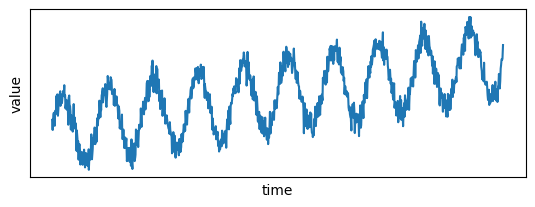

In [ ]:
def set_params_plot():
    plt.xlabel("time")
    plt.ylabel("value")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title("")


# Plot the data points
plt.subplot(2, 1, 1)
set_params_plot()
plt.plot(x, y)

plt.show()

Now you can convert this data to Pandas and load it to Pathway

In [ ]:
import pandas as pd

In [ ]:
import pathway as pw


def load_to_pathway(x, y):
    time_series_pd = pd.DataFrame({"x": x, "y": y})
    return pw.debug.table_from_pandas(time_series_pd)


time_series = load_to_pathway(x, y)

In [ ]:
time_series.typehints()

mappingproxy({'x': float, 'y': float})

And that's it! Now, let's see how to build and apply a Gaussian filter in Pathway.

### Computing aggregations with `windowby`

You want to obtain an aggregation of the closest points for each point.
With streaming data, you do not have any assumption on the distribution of surrounding points.
You can ask for a fixed number of previous/next points, but you'd take the risk to obtain points with very different timestamps.
So the solution is to ask for the data points in an interval around your point.

To do so, you can use `windowby`, that takes three arguments:
 1. The column used for windowing: the timestamp in the column `x`.
 2. The window: in your case you will use an `intervals_over` window.
 3. The optional sharding: not relevant here.

For `intervals_over`, you need to set the parameter `at`, defining the column of times for which windows are to be created and the `lower_bound` and the `upper_bound` of the interval.
Let's try with an interval of length 100:

In [ ]:
points_within_50 = time_series.windowby(
    time_series.x,
    window=pw.temporal.intervals_over(
        at=time_series.x, lower_bound=-50.0, upper_bound=50.0
    ),
).reduce(
    pw.this._pw_window_location,
    xs=pw.reducers.ndarray(pw.this.x),
    ys=pw.reducers.ndarray(pw.this.y),
)

### Gaussian Filtering in Python as a UDF

Now that you have the intervals, you need the Gaussian filter.
In Pathway, you can easily define a User-Defined Function (UDF) with the `@pw.udf` annotation.
To perform a Gaussian filter, you need the data points gathered by the `windowby` and the associated time (called `window_location`).
The times and the values are kept in separate columns, so we takes two different arrays as input:

In [ ]:
import scipy.stats


# UDF for Gaussian filter
@pw.udf
def gaussian_filter(
    times: np.ndarray,
    values: np.ndarray,
    window_location,
) -> float:
    stdev = (max(times) - min(times)) / 2
    gaussian_distribution = scipy.stats.norm(window_location, stdev)

    coefficients = gaussian_distribution.pdf(times)
    normalized_coefficients = coefficients / sum(coefficients)
    return np.dot(values, normalized_coefficients)

With the UDF, you can directly apply the filter to each interval, without using `pw.apply`:

In [ ]:
# Applying the Gaussian filter
time_series_filtered = points_within_50.select(
    x=pw.this._pw_window_location,
    y=gaussian_filter(pw.this.xs, pw.this.ys, pw.this._pw_window_location),
)

### Displaying the output

Let's plot the results.
Let's first output the data in Pandas and then plot the timeseries.
In practice you'd use a [output connector](/developers/user-guide/connect/pathway-connectors/) to output the results to Kafka or Postgres.

In [ ]:
time_series_filtered_pd = pw.debug.table_to_pandas(time_series_filtered)
time_series_filtered_pd = time_series_filtered_pd.sort_values(by=["x"])

[2024-06-13T06:38:13]:INFO:Preparing Pathway computation


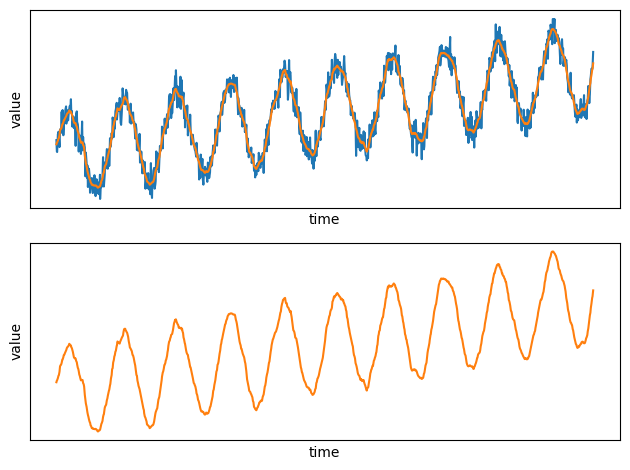

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(x, y)
plt.plot(time_series_filtered_pd.x, time_series_filtered_pd.y)
set_params_plot()

plt.subplot(2, 1, 2)
plt.plot(time_series_filtered_pd.x, time_series_filtered_pd.y, color="#ff7f0e")
set_params_plot()

plt.tight_layout()
plt.show()

See how smooth the new plot is compared to the noisy raw data!

## Gaussian Filtering in Python: Handling Late and Out-of-Order data points

Now that your pipeline is ready, Pathway will manage late and out-of-order points by updating its results whenever new (or late, in this case) data points come into the system.

But what does it mean exactly? What happens when late points arrive?

As a reminder, a standard DSP system will retain the data until all the data is ready to apply the Gaussian filter.
**In a streaming system, you cannot afford to wait for data points for an undetermined time: some data points may be lost and never arrive!
Pathway computes an output with whatever data is available then and revises the result whenever new data points arrive.**

Let's see the impact on late data points in our example by delaying the arrival of several points.

For clarity, let's focus on a small sample of the data:

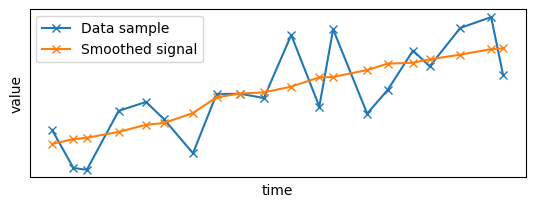

In [ ]:
sample_size = 20
x_sample = x[0:sample_size]
y_sample = y[0:sample_size]
time_series_filtered_x_sample = time_series_filtered_pd.x.tolist()[0:sample_size]
time_series_filtered_y_sample = time_series_filtered_pd.y.tolist()[0:sample_size]

# Plot the data points
plt.subplot(2, 1, 1)
set_params_plot()
plt.plot(x_sample, y_sample, "x-", label="Data sample")
plt.plot(
    time_series_filtered_x_sample,
    time_series_filtered_y_sample,
    "x-",
    label="Smoothed signal",
)
plt.legend()

plt.show()

Until now, the data was considered static and ingested all at once in a single batch: let's switch to streaming data by adding timestamp to the data!

You will create two batches of points: one with all the "on-time" data points arriving at time 0, and another one with "late" data points arriving at a later time.
To make the computation interesting, the late data points should be in the middle of the signal:

In [ ]:
init_late = 6
length_late = 7

# Extracting the late points
x_sample_late = x_sample[init_late : init_late + length_late]
y_sample_late = y_sample[init_late : init_late + length_late]

# Removing the late points from the original sample
x_sample_ontime = x_sample.copy().tolist()
del x_sample_ontime[init_late : init_late + length_late]
y_sample_ontime = y_sample.copy().tolist()
del y_sample_ontime[init_late : init_late + length_late]

# The on-time data points have a timestamp of 0, the other ones have a timestamp of 1
time = [0 for i in range(len(x_sample_ontime))]
for i in range(len(x_sample_late)):
    time.append(1)

out_of_order_x_sample = x_sample_ontime + x_sample_late.tolist()
out_of_order_y_sample = y_sample_ontime + y_sample_late.tolist()

out_of_order_time_series_pd = pd.DataFrame(
    {"x": out_of_order_x_sample, "y": out_of_order_y_sample, "time": time}
)
out_of_order_time_series_pd.to_csv("./ooo_ts.csv", index=False)

Let's plot the resulting data sample: the late points, in red, have been removed from the original time series:

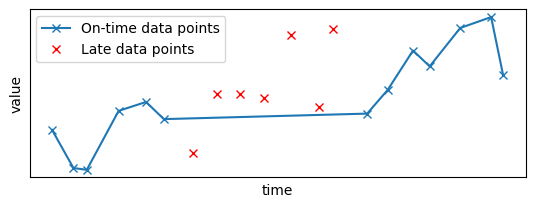

In [ ]:
plt.subplot(2, 1, 1)
set_params_plot()
plt.plot(x_sample_ontime, y_sample_ontime, "x-", label="On-time data points")
plt.plot(x_sample_late, y_sample_late, "x", color="red", label="Late data points")
plt.legend()

plt.show()

Now, you will apply the filter to this data source.
You first need to create a pipeline to apply the Gaussian filter, as done in the previous sections:

In [ ]:
def smooth_table(table):
    points_within_50 = table.windowby(
        table.x,
        window=pw.temporal.intervals_over(
            at=table.x, lower_bound=-50.0, upper_bound=50.0
        ),
    ).reduce(
        pw.this._pw_window_location,
        xs=pw.reducers.ndarray(pw.this.x),
        ys=pw.reducers.ndarray(pw.this.y),
    )
    # Applying the Gaussian filter
    time_series_filtered = points_within_50.select(
        x=pw.this._pw_window_location,
        y=gaussian_filter(pw.this.xs, pw.this.ys, pw.this._pw_window_location),
    )
    return time_series_filtered

Then, you need to read the input source.
You are not working with a static data source anymore, but a streaming one.
You can use `pw.demo.replay_csv_with_time` to replay a data source in a CSV file respecting the time between updates based on a timestamp columns (more information about this function in our dedicated [article](/developers/user-guide/connect/artificial-streams#replaying-static-csv-files-with-replay_csv-and-replay_csv_with_time)). Here the time is contained in the column `time`:

In [ ]:
# For streaming data, you need to define the schema
class InputSchema(pw.Schema):
    x: float
    y: float
    time: int


ooo_input_table = pw.demo.replay_csv_with_time(
    path="ooo_ts.csv",
    schema=InputSchema,
    time_column="time",
    unit="s",
    autocommit_ms=100,
)
ooo_smoothed_table = smooth_table(ooo_input_table)
pw.io.csv.write(ooo_smoothed_table, "ooo_results.csv")
pw.run()

Output()

[2024-06-13T06:38:14]:INFO:Preparing Pathway computation


[2024-06-13T06:38:14]:INFO:PythonReader-0: 0 entries (1 minibatch(es)) have been sent to the engine


[2024-06-13T06:38:14]:INFO:FileWriter-0: Done writing 0 entries, time 1718253494372. Current batch writes took: 0 ms. All writes so far took: 0 ms.


[2024-06-13T06:38:15]:INFO:PythonReader-0: 20 entries (11 minibatch(es)) have been sent to the engine


[2024-06-13T06:38:15]:WARNING:PythonReader-0: Closing the data source


[2024-06-13T06:38:15]:INFO:FileWriter-0: Done writing 38 entries, closing data sink. Current batch writes took: 0 ms. All writes so far took: 0 ms.


Let's take a look at the results:

In [ ]:
results = pd.read_csv("./ooo_results.csv")
results = results.sort_values(by=["x"])
results.head()

,x,y,time,diff
5,2.663173,9.995850,1718253494396,1
23,11.440568,11.651747,1718253495370,1
21,11.440568,10.975576,1718253495370,-1
4,11.440568,10.975576,1718253494396,1
18,16.929219,11.780476,1718253495370,-1


There are two new columns: `time` and `diff`.
The column `time` corresponds to the processing time at which Pathway generated the output, and `diff` represents whether the output was added or removed.
An update is decomposed in two simultaneous atomic operations: the removal of the last value (`diff==-1`) and the addition of the new one (`diff==1`).

Here we have only two batches, so there are only two different values in the column `time`.

Let's see the results of the first batch when the "on-time" data points were added to the system:

In [ ]:
# The first batch has only additions, no need to filter on `diff` (all values are equal to 1).
first_results = results[results["time"] == min(results["time"])]

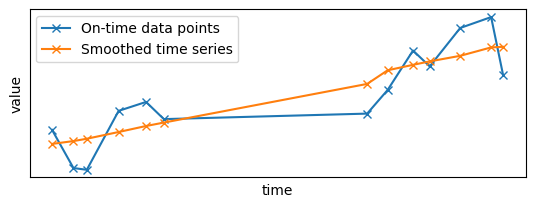

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(x_sample_ontime, y_sample_ontime, "x-", label="On-time data points")
plt.plot(first_results.x, first_results.y, "x-", label="Smoothed time series")
plt.legend()
set_params_plot()

As you can see, there is a gap in the middle of the time series as some points are missing.
However, the Gaussian filter did its job by smoothing the signal with the data points it had at its disposal.

Now, let's see what was the output when the second batch of points was ingested:

In [ ]:
late_results = results[results["time"] == max(results["time"])]
# We only focus on the new values, i.e., with diff==1
late_results = late_results[late_results["diff"] == 1]

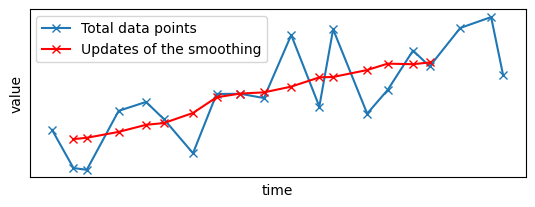

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(x_sample, y_sample, "x-", label="Total data points")
plt.plot(
    late_results.x, late_results.y, "x-", color="red", label="Updates of the smoothing"
)
plt.legend()
set_params_plot()

You can see that the gap has disappeared, replaced by the late data points and the associated smoothed signal.

Let's compare both outputs:

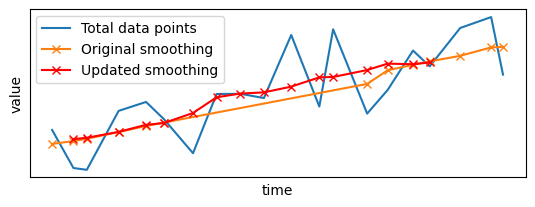

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(x_sample, y_sample, label="Total data points")
plt.plot(
    first_results.x, first_results.y, "x-", color="#ff7f0e", label="Original smoothing"
)
plt.plot(late_results.x, late_results.y, "x-", color="red", label="Updated smoothing")
plt.legend()
set_params_plot()


The arrival of late data points has triggered an update of the output: not only the gap has been filled, but existing values have been updated to take into account the incoming data points.
Furthermore, the smoothing has been updated only for data points close to the late points: Pathway did not apply the filter to the whole signal from scratch, but only updated the local parts that were impacted by the arrival of the late points.

This is the power of Pathway: you can build your pipeline as if the data were static, and Pathway will take care of the late and out-of-order data for you.
**Your results will always be up-to-date compared to the latest available data points.**

## Gaussian Filtering in Python: Conclusion

Signal processing is a fundamental tool for extracting meaningful insights from data, but signal processing on real-world data requires data alignment.
Pathway provides all you need to tackle the challenges of real-world digital signal processing on data streams.
Now that you understand the differences between idealized signal processing and data stream processing, I'm sure you can leverage Pathway's capabilities to process, filter, and analyze data efficiently, even when dealing with imperfect sampling rates and data imperfections.

If you want to learn more about DSP in Pathway, try our [tutorial](/developers/showcases/upsampling/) about manipulating different data sources by *upsampling* a data source to match the sampling rate of given data source.